In [1]:
from __future__ import division
import os.path as op
import itertools
import numpy as np
import scipy as sp
import pandas as pd
import nibabel as nib
from scipy import stats
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
import lyman
from lyman import mvpa, evoked
import seaborn as sns
import moss

In [2]:
%matplotlib inline
sns.set(context="paper", style="ticks", font="Arial")
mpl.rcParams.update({"xtick.major.width": 1, "ytick.major.width": 1, "savefig.dpi": 150})
pd.set_option('display.precision', 3)

In [3]:
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

In [4]:
np.random.seed(sum(map(ord, reversed("featurediscrimination"))))

In [5]:
from IPython.parallel import Client, TimeoutError
try:
    dv = Client()[:]
    dv4 = Client()[:4]
except (IOError, TimeoutError):
    dv = None
    dv4 = None

In [6]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [7]:
def save_figure(fig, figname):
    fig.savefig("figures/%s.pdf" % figname, dpi=300)
    fig.savefig("figures/%s.tiff" % figname, dpi=300)

NameError: name 'home_dir' is not defined

In [25]:
project = lyman.gather_project_info()
anal_dir = project["analysis_dir"]
data_dir = project["data_dir"]
home_dir = '/data/home/iballard/fd/'

subj_file = home_dir + 'subjects_ser.txt'
subjects = list(np.loadtxt(subj_file,'string'))

In [26]:
all_rois = pd.Series(["lOFC_fill_ser", "mOFC_fill_ser"], name="roi")

In [27]:
frames = np.arange(-1, 5)
timepoints = frames * 1.5 + 1
up_timepoints = (np.linspace(0, 12, 25) - 1)[:-1]
model = LogisticRegression()
n_shuffle = 1000
peak = slice(2, 4)
shuffle_seed = sum(map(ord, "featurediscrimination"))

In [28]:
roi_colors = dict(lOFC="#CC3333", mOFC="#3380CC",)
# roi_colors.update({"aIFS": "#863D3D", "pIFS": "#7A5252",
#                    "lh-IFS": "#D19494", "rh-IFS": "#C2A3A3"})

In [29]:
def dksort_roi_sizes():
    roi_sizes = pd.DataFrame(columns=all_rois, index=subjects, dtype=float)
    mask_template = op.join(data_dir, "%s/masks/%s.nii.gz")
    for roi in roi_sizes:
        for subj in subjects:
            vox_count = nib.load(mask_template % (subj, roi)).get_data().sum()
            roi_sizes.loc[subj, roi] = vox_count
    return roi_sizes.describe().loc[["mean", "std"]].astype(int)
dksort_roi_sizes()

,lOFC_fill_ser,mOFC_fill_ser
mean,5955,4029
std,443,309


In [31]:
def fd_roi_signal():
    roi_signal = pd.DataFrame(columns=all_rois, index=subjects, dtype=float)
    for roi in all_rois:
        signal = evoked.extract_group(roi, dv=dv4)
        signal = [np.concatenate(d["data"]).mean() for d in signal]
        roi_signal[roi] = signal
    return (roi_signal / 100).describe().loc[["mean", "std"]]

In [32]:
def fd_artifact_counts():
    artifacts = []
    for subj in subjects:
        if subj == 'fd_127' or subj == 'fd_133':
            nruns = 2
        else:
            nruns = 3
        subj_artifacts = 0
        for run in range(1, nruns + 1):
            art = pd.read_csv(op.join(anal_dir, "sim_8mm/%s/preproc/run_%d/artifacts.csv" % (subj, run)))
            art = art.max(axis=1)
            subj_artifacts += art.sum()
        artifacts.append(subj_artifacts)
    print "Mean number of artifacts: %d" % np.mean(artifacts)
    print "Percent artifact scans: %.1f%%" % (np.mean(artifacts) / 2328 * 100)
fd_artifact_counts()



Mean number of artifacts: 27
Percent artifact scans: 1.2%


In [33]:
def fd_decode(rois, cond):
    """Do the all the main decoding steps across sets of ROIs.
    
    Parameters
    ----------
    rois: list of strings
        list of ROI names that can be easily mapped to a mask name
    cond: string
        name of condition corresponding to design file in data dir

    Returns
    -------
    dictionary with the following entries
        rois: list of roi names
        accs: DataFrame with decoding accuracy. Index is hierarchical with
              (ROI, subject), and columns are timepoint.
        chance: DataFrame in same shape as `accs` with the mean value from
                the shuffled null distribution for each test.
        peak: DataFrame with decoding accuracy from data averaged over 3s
              and 5s. Index is subject id and column is ROI.
        null: DataFrame with maximum shuffled accuracy across timepoints.
              Index is hierarchical with (subj, iteration) and columns
              are ROIS.
        ttest: DataFrame with ROIs in the index and (t, p, max_tp) for the
               group average test against empirical chance in the
               columns. `t` is the t statistic for the peak accuracy value,
               and `p` is the corresponding p value corrected for multiple
               comparisons across region and timepoint. max_tp is in seconds
               relative to stimulus onset.
        signif: DataFrame with the null distribution percentiles corresponding
                to the best observed accuracy for each subject/ROI. Index is
                hierarchical with (correction, subject) where correction can be
                `time` or `omni` for the space of tests the percentile is corrected
                against. columns are ROIs.
                
    """    
    # Set up the DataFrames to hold the persisent outputs
    roi_index = moss.product_index([rois, subjects], ["ROI", "subj"])
    columns = pd.Series(timepoints, name="timepoints")
    accs = pd.DataFrame(index=roi_index, columns=columns, dtype=float)

    null_index = moss.product_index([subjects, np.arange(n_shuffle)], ["subj", "iter"])
    null = pd.DataFrame(index=null_index, columns=pd.Series(rois, name="ROI"), dtype=float)

    peak_df = pd.DataFrame(index=subjects, columns=pd.Series(rois, name="ROI"))
    chance = pd.DataFrame(index=roi_index, columns=timepoints, dtype=float)
    
    # For each ROI load the data, decode, and simulate the null distribution
    for roi in rois:
#         mask = "yeo17_" + roi.lower()
        mask = roi
        
        # Load the dataset and do the basic time-resolved decoding
#         ds = mvpa.extract_group(rule, roi, mask, frames, confounds="rt", dv=dv4)
        ds = mvpa.extract_group(cond, roi, mask, frames,exp_name='ser_8mm', dv=dv)
        roi_accs = mvpa.decode_group(ds, model, dv=dv)
        accs.loc[roi, :] = roi_accs
        
        # Now do the shuffling and save the partially transformed null distribution
        roi_null = mvpa.classifier_permutations(ds, model, n_iter=n_shuffle,
                                                random_seed=shuffle_seed, dv=dv)
        chance.loc[roi, :] = roi_null.mean(axis=1)
        null[roi] = roi_null.max(axis=-1).ravel()

        # Finally re-load the data averaging over the peak timepoints and decode
        peak_ds = mvpa.extract_group(cond, roi, mask, frames, peak, dv=dv4)
        peak_df[roi] = mvpa.decode_group(peak_ds, model, dv=dv)

    # Do the group t tests
    wide_accs = accs.unstack(level="ROI")
    wide_chance = chance.unstack(level="ROI")
    mus = wide_accs.mean(axis=0)
    sds = wide_accs.std(axis=0)
    ts, ps = moss.randomize_onesample(wide_accs, h_0=wide_chance)

    # Build the t test output
    t_df = pd.DataFrame(dict(t=ts, p=ps, mu=mus, sd=sds),
                        index=wide_accs.columns, columns=["mu", "sd", "t", "p"])
    ttest = t_df.groupby(level="ROI").apply(lambda x: x.loc[x.mu.idxmax()])
    ttest["tp"] = t_df.groupby(level="ROI").mu.apply(lambda x: x.idxmax()[0])

    # From the null distribution, find the percentile corresponding to the observed score
    signif_index = moss.product_index([["time", "omni"], subjects], ["correction", "subj"])    
    signif = pd.DataFrame(index=signif_index, columns=rois, dtype=float)
    for roi, roi_accs in accs.max(axis=1).groupby(level="ROI"):
        for subj, score in roi_accs.groupby(level="subj"):
            signif.loc[("time", subj), roi] = stats.percentileofscore(null[roi], score[0])
            signif.loc[("omni", subj), roi] = stats.percentileofscore(null.max(axis=1), score[0])    

    return dict(rois=rois, accs=accs, chance=chance, peak=peak_df,
                null=null, ttest=ttest, signif=signif)

In [34]:
subjects = pd.Series(lyman.determine_subjects(), name="subj")
print subjects
ofc_state_sim = fd_decode(all_rois, "ser_state")

0     fd_104
1     fd_105
2     fd_107
3     fd_108
4     fd_109
5     fd_110
6     fd_113
7     fd_114
8     fd_115
9     fd_117
10    fd_118
11    fd_119
12    fd_122
13    fd_123
14    fd_124
15    fd_126
16    fd_127
17    fd_128
18    fd_129
19    fd_130
20    fd_132
21    fd_133
22    fd_135
23    fd_136
24    fd_137
25    fd_138
26    fd_140
Name: subj, dtype: object


CompositeError: one or more exceptions from call to method: extract_subject
[0:apply]: IndexError: list index out of range
[1:apply]: IndexError: list index out of range
[2:apply]: IndexError: list index out of range
[3:apply]: IndexError: list index out of range
.... 11 more exceptions ...

In [26]:
print ofc_state_sim

{'rois': 0    lOFC
1    mOFC
Name: roi, dtype: object, 'chance':              -0.5   1.0   2.5   4.0   5.5   7.0
ROI  subj                                      
lOFC fd_104   0.5   0.5   0.5   0.5   0.5   0.5
     fd_105   0.5   0.5   0.5   0.5   0.5   0.5
     fd_107   0.5   0.5   0.5   0.5   0.5   0.5
     fd_108   0.5   0.5   0.5   0.5   0.5   0.5
     fd_109   0.5   0.5   0.5   0.5   0.5   0.5
mOFC fd_104   0.5   0.5   0.5   0.5   0.5   0.5
     fd_105   0.5   0.5   0.5   0.5   0.5   0.5
     fd_107   0.5   0.5   0.5   0.5   0.5   0.5
     fd_108   0.5   0.5   0.5   0.5   0.5   0.5
     fd_109   0.5   0.5   0.5   0.5   0.5   0.5, 'peak': ROI     lOFC  mOFC
subj              
fd_104  0.47  0.53
fd_105  0.42  0.45
fd_107  0.52  0.58
fd_108  0.49  0.62
fd_109  0.46  0.53, 'signif': roi                 lOFC   mOFC
correction subj                
time       fd_104  20.31  43.78
           fd_105  68.53  43.78
           fd_107  75.05  90.43
           fd_108  20.31  10.54
           fd_

In [41]:
def dksort_timecourse_figure(ax, data, ytick_args, err_style="ci_band", legend=True, err_kws=None, **kwargs):
    """Plot time-resolved decoding accuracies for multiple ROIs"""
    # Represent chance empirically based on the null distribution
    chance = np.array(data["chance"].mean(axis=0))
    ax.plot(timepoints, chance, "k--")

    # Plot the stimulus onset
    ax.plot([0, 0], ytick_args[:2], ls=":", c="k")
    
    # Draw the accuracy timecourse for each ROI
    colors = [roi_colors[roi] for roi in data["rois"]]
    interpolate = not err_style == "ci_bars"
    accs = pd.melt(data["accs"].reset_index(), ["subj", "ROI"], value_name="acc")
    sns.tsplot(accs, time="timepoints", unit="subj", condition="ROI", value="acc",
               color=colors, err_style=err_style, interpolate=interpolate, legend=legend,
               err_kws=err_kws, ax=ax, **kwargs)

    # Adjust the axis scales and tick labels
    ylim = ytick_args[:2]
    yticks = np.linspace(*ytick_args)
    
    ax.set_xlim(timepoints.min(), timepoints.max())
    ax.set_ylim(ylim)
    ax.set_yticks(yticks)

    # Label the axes
    ax.set_xlabel("Time relative to stimulus onset (s)")
    ax.set_ylabel("Cross-validated decoding accuracy")
    
    # Make a legend with the ROIs
    ax.legend(frameon=False, loc="upper right")

NameError: name 'ofc_state' is not defined

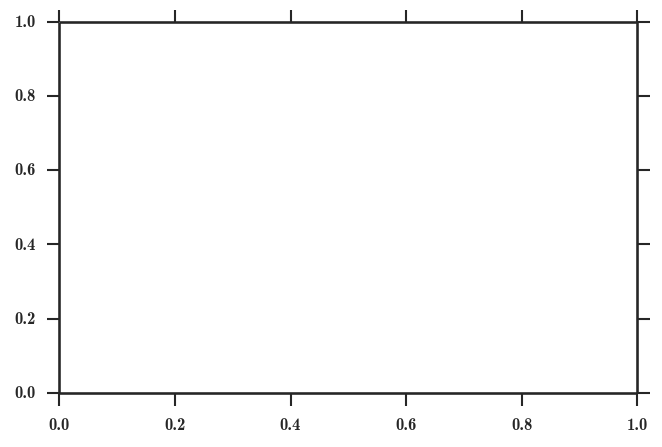

In [42]:
f = plt.figure(figsize=(4.48, 5.5))

ax_ts = f.add_axes([.12, .53, .86, .45])
dksort_timecourse_figure(ax_ts, ofc_state, (.43, .57, 5))
plt.savefig('ser_decoding.tiff', dpi=600, orientation = 'landscape')

/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1246: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=8.8. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf
  UserWarning)


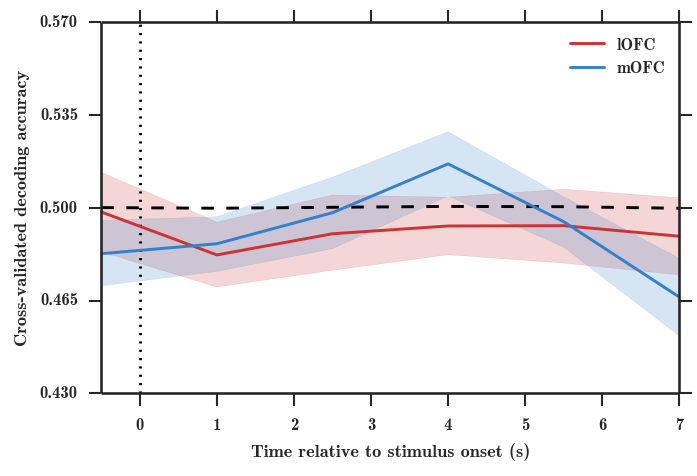

In [43]:
f = plt.figure(figsize=(4.48, 5.5))

ax_ts = f.add_axes([.12, .53, .86, .45])
dksort_timecourse_figure(ax_ts, ofc_state_sim, (.43, .57, 5))
plt.savefig('sim_decoding.tiff', dpi=600, orientation = 'landscape')